<a href="https://colab.research.google.com/github/stepan-fukalov/ml/blob/master/geometric_shapes_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating and detecting geometic shapes

In [1]:
import locale
import os
import json
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
from PIL import ImageFilter
from pathlib import Path
from google.colab import drive
from tqdm.auto import tqdm

drive.mount('/content/gdrive')
locale.getpreferredencoding = lambda: "UTF-8"

Mounted at /content/gdrive


## Data Generator

In [2]:
INF = float("inf")
alpha = ("0", "1", "2", "3", "4", "5", "6", "7", "8", "9",
             "A", "B", "C", "D", "E", "F")
IM_SIZE = 256
classes = ['circle', 'triangle', 'rectangle', 'diamond', 'hexagon']

def randbetween(n1,n2):
        return np.random.randint(low=n1,high=n2+1,size=None)

def randcolor():
    return '#'+''.join([np.random.choice(alpha) for _ in range(6)])

def get_random_colors(n):
    colors = [randcolor() for _ in range(n)]
    isDifferent = True
    for i in range(n):
        for j in range(i+1, n):
            if(colors[i] == colors[j]):
                isDifferent = False
    return colors if isDifferent else get_random_colors(n)

def getDetectionRect(points_x, points_y):
    x1, x2 = INF, -INF
    y1, y2 = INF, -INF
    for x in points_x:
        x1 = min(x1, x)
        x2 = max(x2, x)
    for y in points_y:
        y1 = min(y1, y)
        y2 = max(y2, y)
    return (x1, y1, x2, y2)

def drawRectangle(draw, x1, y1, x2, y2):
    draw.polygon([(x1, y2), (x1, y1), (x2, y1),(x2,y2)], outline='#000000')

def polygon(sides, radius=1, rotation=0, translation=None):
    one_segment = math.pi * 2 / sides

    points = [
        (math.sin(one_segment * i + rotation) * radius,
         math.cos(one_segment * i + rotation) * radius)
        for i in range(sides)]

    if translation:
        points = [[sum(pair) for pair in zip(point, translation)]
                  for point in points]

    return points

def get_vector_distance(x1, y1, x2, y2):
    return math.sqrt(pow(x1-x2, 2)+pow(y1-y2, 2))

def triangle_area_heron(a, b, c):
    s = (a + b + c) / 2
    area = math.sqrt(s * (s - a) * (s - b) * (s - c))
    return area

def check_triangle(points):
    a = get_vector_distance(*points[0], *points[1])
    b = get_vector_distance(*points[0], *points[2])
    c = get_vector_distance(*points[1], *points[2])
    valid = (a+b-c) >= 5 and (a+c-b) >= 5 and (b+c-a) >= 5
    if not valid:
        return False
    S = triangle_area_heron(a, b, c)
    return S >= 35

def check_diamond(points):
    a = get_vector_distance(*points[0], *points[1])
    b = get_vector_distance(*points[0], *points[2])
    return abs(a-b) >= 10

def createcircle():
    x1=randbetween(0,IM_SIZE)
    y1=randbetween(0,IM_SIZE)
    x2=randbetween(x1, IM_SIZE)
    y2=randbetween(y1, IM_SIZE)
    det_points = getDetectionRect((x1, x2), (y1, y2))
    return (x1, y1, x2, y2), det_points

def createtriangle():
    x1=randbetween(0,IM_SIZE)
    x2=randbetween(0,IM_SIZE)
    x3=randbetween(0,IM_SIZE)
    y1=randbetween(0,IM_SIZE)
    y2=randbetween(0,IM_SIZE)
    y3=randbetween(0,IM_SIZE)
    points = [(x1,y1), (x2, y2), (x3,y3)]
    det_points = getDetectionRect((x1, x2, x3), (y1, y2, y3))
    return points, det_points

def createrectangle():
    x1=randbetween(0,IM_SIZE)
    x2=randbetween(x1,IM_SIZE)
    x4=x1
    x3=x2
    y1=randbetween(0,IM_SIZE)
    y3=randbetween(y1,IM_SIZE)
    y2=y1
    y4=y3
    points = [(x1,y1), (x2, y2), (x3,y3),(x4,y4)]
    det_points = getDetectionRect((x1, x2, x3, x4), (y1, y2, y3, y4))
    return points, det_points

def creatediamond():
    x1=randbetween(0,IM_SIZE)
    x2=randbetween(x1, IM_SIZE)
    x4=x1
    x3=x2
    y1=randbetween(0,IM_SIZE)
    y3=randbetween(y1,IM_SIZE)
    y2=y1
    y4=y3
    w = x2-x1
    h = y3-y1
    x1 += w/2
    y2 += h/2
    x3 -= w/2
    y4 -= h/2
    points = [(x1,y1), (x2, y2), (x3,y3),(x4,y4)]
    det_points = getDetectionRect((x1, x2, x3, x4), (y1, y2, y3, y4))
    return points, det_points

def createhexagon():
    r=randbetween(0, IM_SIZE/5)
    t1=randbetween(IM_SIZE/4, IM_SIZE/4*3)
    t2=randbetween(IM_SIZE/4, IM_SIZE/4*3)
    t3=randbetween(IM_SIZE/4, IM_SIZE/4*3)
    angle=randbetween(0,360)
    pg=polygon(6,radius=r,rotation=angle,translation=(t1,t2,t3))
    points = [tuple(pg[0]),tuple(pg[1]),tuple(pg[2]),tuple(pg[3]),tuple(pg[4]), tuple(pg[5])]
    det_points = getDetectionRect([x[0] for x in pg], [x[1] for x in pg])
    return points, det_points

def is_intersect(rect1, rect2):
    if rect1[0] > rect2[2] or rect1[2] < rect2[0]:
        return False
    if rect1[1] > rect2[3] or rect1[3] < rect2[1]:
        return False
    return True

def check_rectangle_size(rect):
    len_1 = abs(rect[0]-rect[2])
    len_2 = abs(rect[1]-rect[3])
    if(len_1 > len_2):
        len_1, len_2 = len_2, len_1
    return len_1 >= 25 and len_2 <= 150

class Generator:
    def __init__(self):
        os.makedirs('./datasets/generated_data', exist_ok=True)
        os.makedirs('./datasets/generated_data/images', exist_ok=True)
        os.makedirs('./datasets/generated_data/annotations', exist_ok=True)
        os.makedirs('./datasets/generated_data/images/train', exist_ok=True)
        os.makedirs('./datasets/generated_data/annotations/train', exist_ok=True)
        os.makedirs('./datasets/generated_data/images/val', exist_ok=True)
        os.makedirs('./datasets/generated_data/annotations/val', exist_ok=True)

    def create_figure(self, figure_id):
        if figure_id == 0:
            return createcircle()
        elif figure_id == 1:
            return createtriangle()
        elif figure_id == 2:
            return createrectangle()
        elif figure_id == 3:
            return creatediamond()
        return createhexagon()

    def generate(self, figure_ids, filename):
        n = len(figure_ids)
        while True:
            figures = []
            detections = []
            for fig_id in figure_ids:
                fig, det = self.create_figure(fig_id)
                figures.append(fig)
                detections.append(det)
            not_intersect = True
            for i in range(len(detections)):
                for j in range(i+1, len(detections)):
                    if(is_intersect(detections[i], detections[j])):
                        not_intersect = False
            valid = not_intersect
            for d in detections:
                valid &= check_rectangle_size(d)
            for fig_id, fig in zip(figure_ids, figures):
                if(classes[fig_id] == 'triangle'):
                    valid &= check_triangle(fig)
                elif(classes[fig_id] == 'diamond'):
                    valid &= check_diamond(fig)
            if(valid):
                colors = get_random_colors(n+1)
                im = Image.new('RGB', (IM_SIZE, IM_SIZE))
                draw = ImageDraw.Draw(im)
                draw.polygon([(0, 0), (0, IM_SIZE), (IM_SIZE, IM_SIZE), (IM_SIZE, 0)], fill = colors[0])
                for i, (fig_id, fig) in enumerate(zip(figure_ids, figures)):
                    if(classes[fig_id] == 'circle'):
                        draw.ellipse(fig, fill=colors[i+1])
                    else:
                        draw.polygon(fig, fill=colors[i+1])
                # im.save('./datasets/generated_data/images/'+filename+'.png')
                # for d in detections:
                    # draw.polygon([(d[0], d[1]), (d[0], d[3]), (d[2], d[3]), (d[2], d[1])], outline='#18a7b5')
                # print(f"Generated: {filename}")
                annotations = [{'id': fig_id, 'x': det[0], 'y': det[1],
                                'w': det[2]-det[0], 'h': det[3]-det[1]}
                               for fig_id, det in zip(figure_ids, detections)]
                return (im, annotations)

In [3]:
generator = Generator()

def generate_images(dir_path, split_name, n):

  for i in tqdm(range(1, n+1)):
      filename = str(i)
      input_data = random.sample(range(5), random.randint(1, 4))
      image, annotations = generator.generate(input_data, filename)
      with open(f"{dir_path}/annotations/{split_name}/{filename}.json", "w") as fh:
          json.dump(annotations, fh)
      image.save(f'{dir_path}/images/{split_name}/{filename}.png')

In [4]:
# dir_path = './datasets/generated_data'
# generate_images(dir_path, "train", 5000)
# generate_images(dir_path, "val", 1000)
!scp -r '/content/gdrive/MyDrive/Colab Notebooks/geometric_shapes_recognition/data.zip' '/content'
!unzip -o  -q 'data.zip'

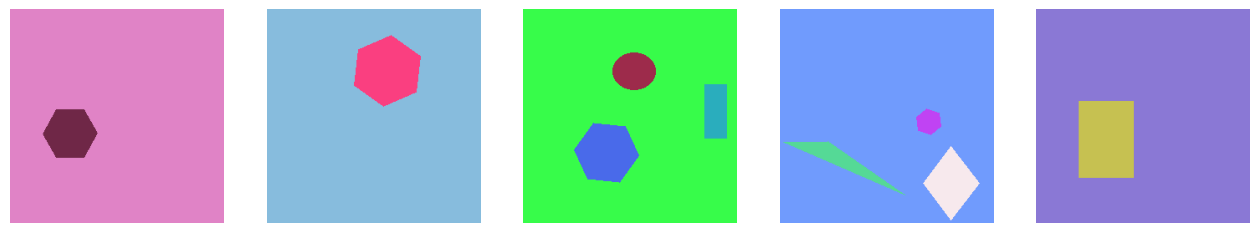

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
fig = plt.figure(figsize=(16, 7))
for i in range(1, 6):
  ax = plt.subplot(1, 5, i)
  ax.axis('off')
  plt.imshow(Image.open(f"datasets/data/images/train/{i}.png"))

In [6]:
!mkdir -p /content/datasets/data
!mkdir -p /content/datasets/data/images
!mkdir -p /content/datasets/data/labels
!mkdir -p /content/datasets/data/labels/train
!mkdir -p /content/datasets/data/labels/val

yolo_annotations_dir = "./datasets/data/labels"
os.makedirs(yolo_annotations_dir, exist_ok=True)

def convert_json_to_yolo_annotations(annotations_dir_path, split_name):
  anot_files = next(iter(os.walk(f"{annotations_dir_path}/{split_name}")))[2]
  for file in anot_files:
    with open(f"{annotations_dir_path}/{split_name}/{file}", "r") as fh:
      json_data = json.load(fh)
    write_data = ""
    for i, box in enumerate(json_data):
      id, x, y, w, h = box['id'], box['x'], box['y'], box['w'], box['h']
      yolo_x = (x+w/2)/256
      yolo_y = (y+h/2)/256
      yolo_w = w/256
      yolo_h = h/256
      write_data += f"{id} {yolo_x} {yolo_y} {yolo_w} {yolo_h}"
      if i != len(json_data)-1:
        write_data += "\n"
    with open(f"{yolo_annotations_dir}/{split_name}/{file.split('.')[0]}.txt", "w") as fh:
      fh.write(write_data)

# convert_json_to_yolo_annotations("./datasets/generated_data/annotations", "train")
# convert_json_to_yolo_annotations("./datasets/generated_data/annotations", "val")

# !scp -r /content/datasets/generated_data/images/train /content/datasets/data/images
# !scp -r /content/datasets/generated_data/images/val /content/datasets/data/images

In [7]:
# !zip -r data.zip "datasets/data" -q

## Training

In [8]:
# !rm -rf /content/datasets/data/images
# !rm -rf /content/datasets/data/labels
# !rm -rf /content/datasets/generated_data

### First training

In [9]:
!pip install -q ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.2/614.2 kB 5.0 MB/s eta 0:00:00


In [10]:
!scp -r '/content/gdrive/MyDrive/Colab Notebooks/geometric_shapes_recognition/config.yaml' '/content/config.yaml'

In [11]:
from ultralytics import YOLO

# model = YOLO("yolov8n.yaml")
# results = model.train(data=os.path.join("./", 'config.yaml'), epochs=5)
!scp -r '/content/gdrive/MyDrive/Colab Notebooks/geometric_shapes_recognition/train' '/content'

In [12]:
# !scp -r /content/runs/detect/train '/content/gdrive/MyDrive/Colab Notebooks/geometric_shapes_recognition'

### Final training

In [13]:
# model.load("runs/detect/train/weights/best.pt")
# model.train(data=os.path.join("./", 'config.yaml'), epochs=5)

# model.load("train/best.pt")
!scp -r '/content/gdrive/MyDrive/Colab Notebooks/geometric_shapes_recognition/train2' '/content'

In [14]:
# !scp -r /content/runs/detect/train2 '/content/gdrive/MyDrive/Colab Notebooks/geometric_shapes_recognition'

## Get validation information

In [15]:
# model.load("runs/detect/train2/weights/best.pt")
# model.load("train2/weights/best.pt")
# model.val()

!scp -r '/content/gdrive/MyDrive/Colab Notebooks/geometric_shapes_recognition/val1' '/content'

In [16]:
# !scp -r /content/runs/detect/val /content/runs/detect/val1
# !scp -r /content/runs/detect/val1 '/content/gdrive/MyDrive/Colab Notebooks/geometric_shapes_recognition'

## Validation analysis

### PR curve
Based on PR curve we can see that model doing pretty good job. Model misses with distincting figures only in 0.5% cases.

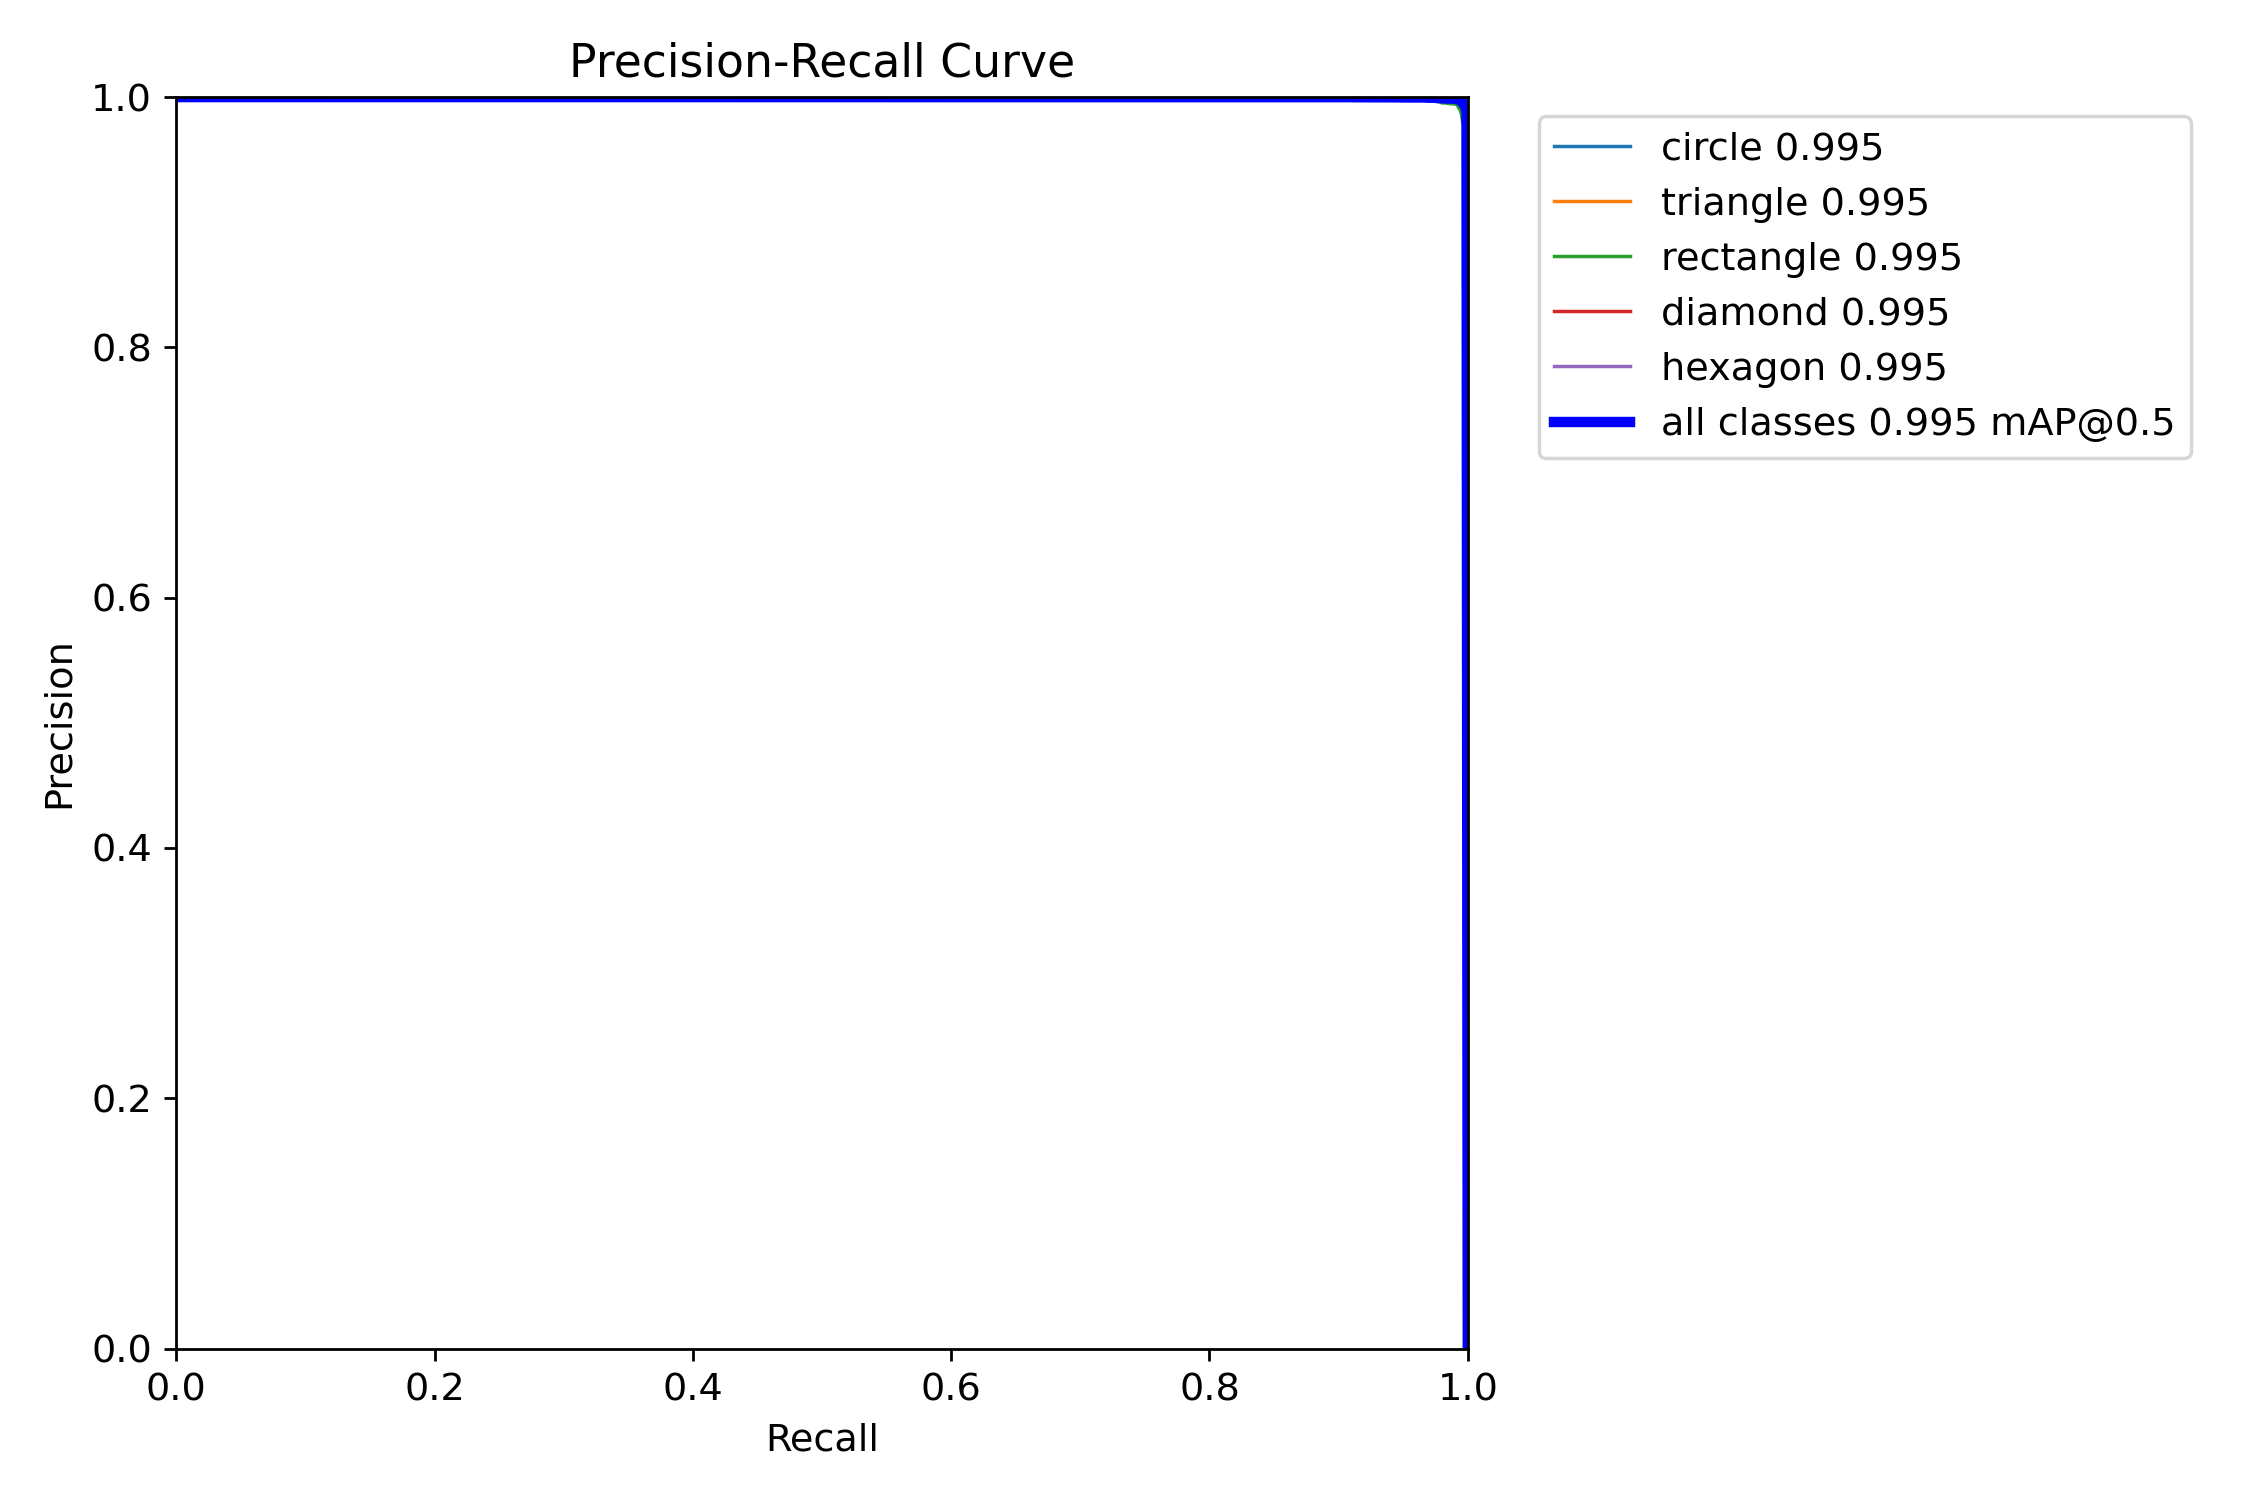

In [17]:
Image.open("val1/PR_curve.png")

### Confusion matrix
Information on matrix shows that model almost perfectly distincts figures between each other. Nethertheless model see figures in places there no figure at all. And it happens too many times. Espesially, in a case of rectangle and triangle.

I think reasons why model see figures in background are:
1. Only if model knows that rectangle is other color than background, it can improve predictions.
2. Default augmentation of data is irrelevant in case of this task. So it should to be disabled.

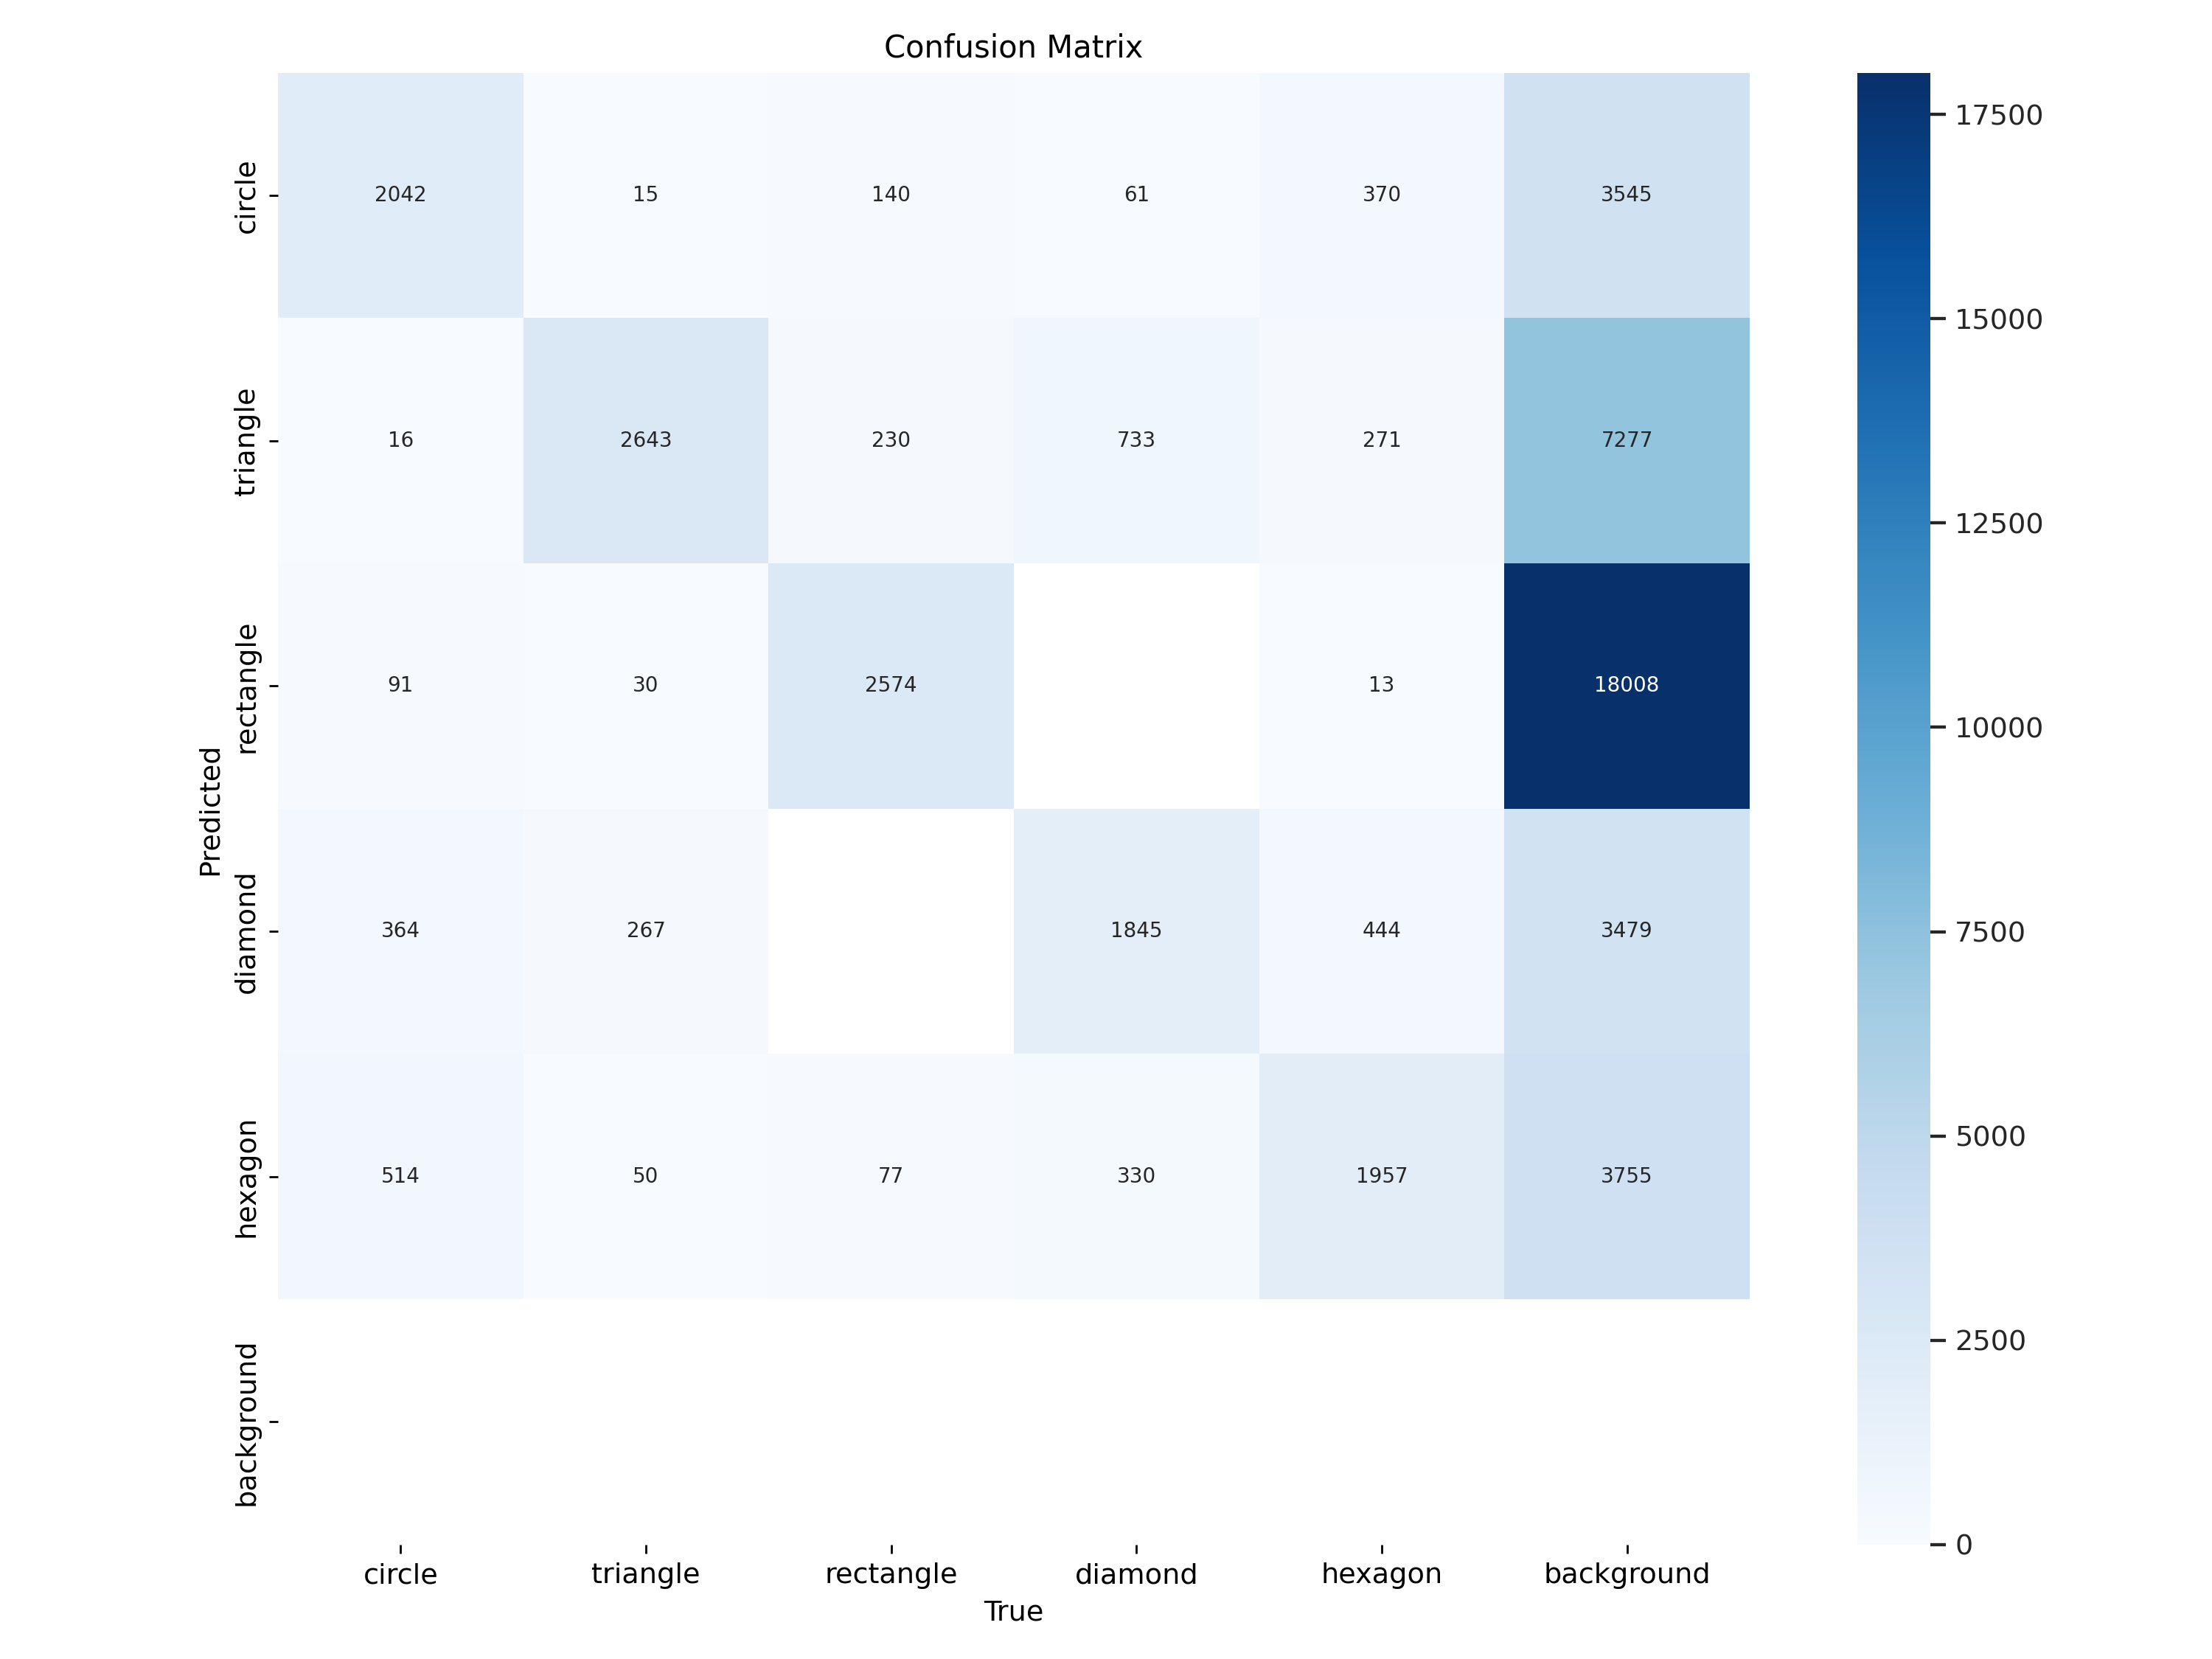

In [18]:
Image.open("val1/confusion_matrix.png")

### Labels vs Predicitons
Great!
Labels and prections are almost identical.

But as I mentioned earlier, there are some problems with confusion of figure and background. See bottom-right example in both images.

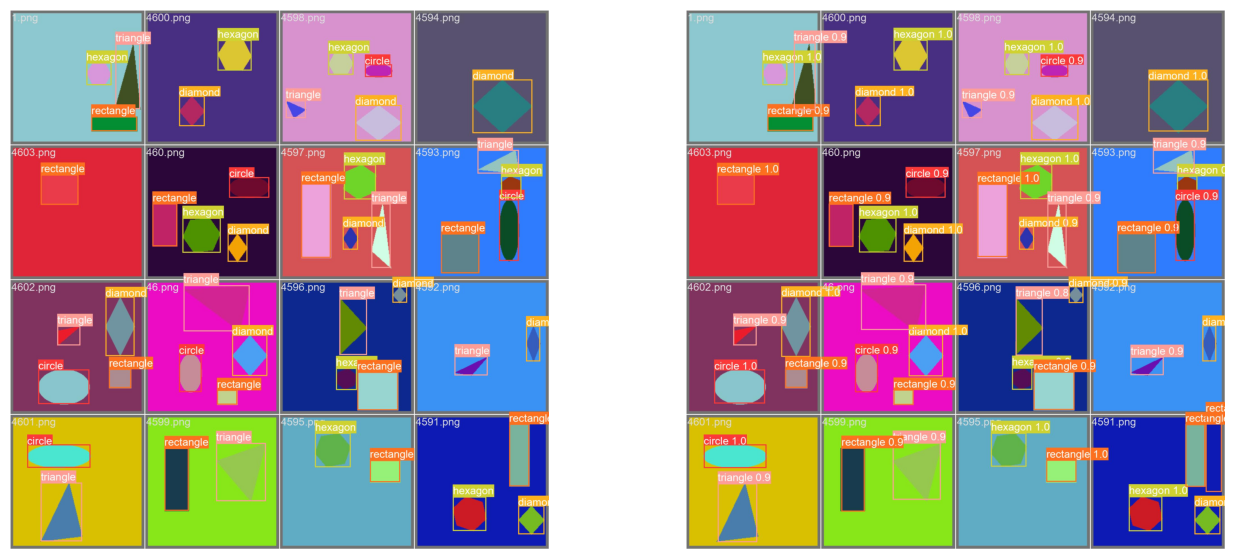

In [19]:
fig = plt.figure(figsize=(16, 7))
ax = plt.subplot(1, 2, 1)
ax.axis('off')
plt.imshow(Image.open("val1/val_batch0_labels.jpg"))
ax = plt.subplot(1, 2, 2)
ax.axis('off')
plt.imshow(Image.open("val1/val_batch0_pred.jpg"))

# Training 2: No Augmentation and Correct Image Size

In [20]:
ARGS = {
    'imgsz': 256, # size of input images as integer or w,h
    'hsv_h': 0, #	image HSV-Hue augmentation (fraction)
    'hsv_s': 0, #	image HSV-Saturation augmentation (fraction)
    'hsv_v': 0, #	image HSV-Value augmentation (fraction)
    'degrees': 0.0, #	image rotation (+/- deg)
    'translate': 0.0, #	image translation (+/- fraction)
    'scale': 0.0, #	image scale (+/- gain)
    'shear': 0.0, #	image shear (+/- deg)
    'perspective': 0.0, #	image perspective (+/- fraction), range 0-0.001
    'flipud': 0.0, #	image flip up-down (probability)
    'fliplr': 0.0, #	image flip left-right (probability)
    'mosaic': 0.0, #	image mosaic (probability)
    'mixup': 0.0, #	image mixup (probability)
    'copy_paste': 0.0, #	segment copy-paste (probability)
}

In [21]:
# model2 = YOLO(model="yolov8n.yaml")
# results = model2.train(data="config.yaml", **ARGS, epochs=5)

!scp -r '/content/gdrive/MyDrive/Colab Notebooks/geometric_shapes_recognition/train3' '/content'

## Training 2: Final training

In [22]:
# model2.load("train3/weights/best.pt")
# results = model2.train(data="config.yaml", **ARGS, epochs=5)

!scp -r '/content/gdrive/MyDrive/Colab Notebooks/geometric_shapes_recognition/train4' '/content'

In [23]:
# model2.val()
!scp -r '/content/gdrive/MyDrive/Colab Notebooks/geometric_shapes_recognition/val2' '/content'

## Validation analysis 2
Based on validation metrics and results, I can say with confidence that training without augmentation shows worse results than with default augmentation.
Confusion matrix shows that model sees rectangle in background more often now.

I found the video in which person explains what may cause this problem. https://www.youtube.com/watch?v=auEvX0nO-kw&ab_channel=StephaneCharette

He says that YOLO models look not only to content of bounding boxes but also to context of image. For example, in this video model detects card symbols instead of whole card and it's hard for the model to distinguish 6 and 9 number on a card because of card rotation.

So the conclusion is that I need to find another NN model for this task. Maybe more simple or more specific for this type of CV problems.

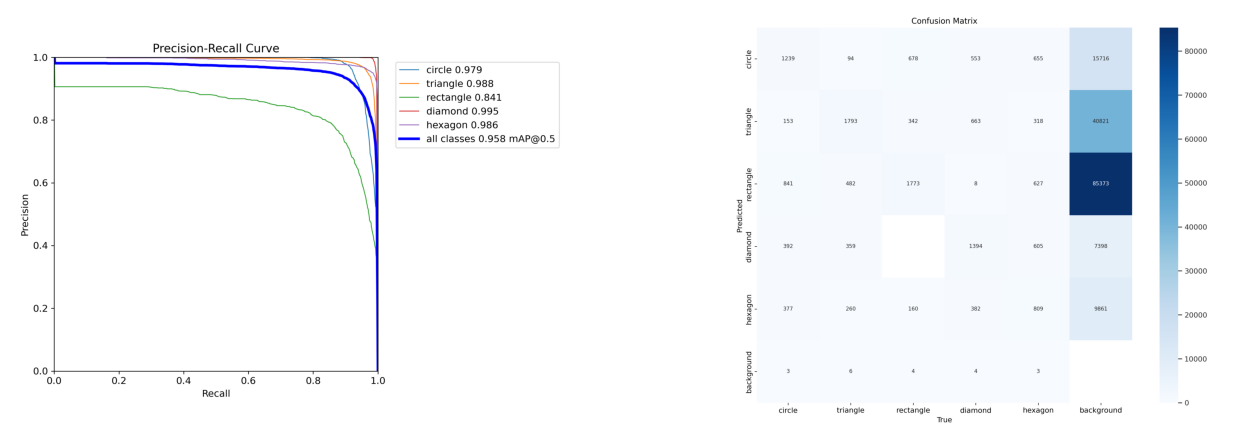

In [24]:
fig = plt.figure(figsize=(16, 7))
ax = plt.subplot(1, 2, 1)
ax.axis('off')
plt.imshow(Image.open("val2/PR_curve.png"))
ax = plt.subplot(1, 2, 2)
ax.axis('off')
plt.imshow(Image.open("val2/confusion_matrix.png"))

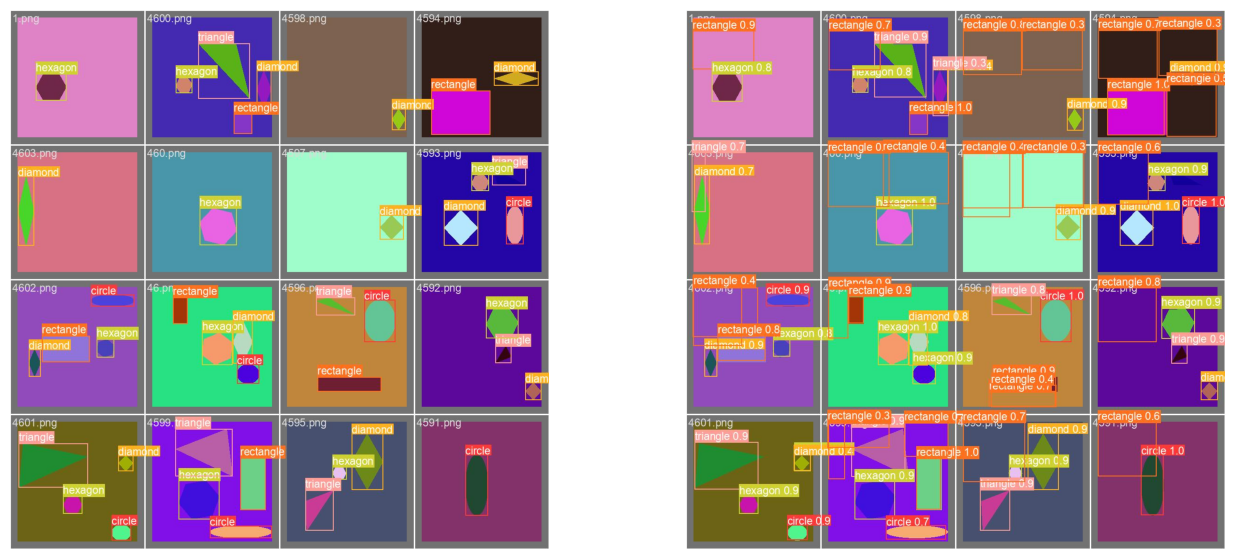

In [25]:
fig = plt.figure(figsize=(16, 7))
ax = plt.subplot(1, 2, 1)
ax.axis('off')
plt.imshow(Image.open("/content/val2/val_batch0_labels.jpg"))
ax = plt.subplot(1, 2, 2)
ax.axis('off')
plt.imshow(Image.open("/content/val2/val_batch0_pred.jpg"))

# Faster-RCNN

In [26]:
# dir_path = 'datasets/generated_data'
# generate_images(dir_path, "train", 5000)

# !mkdir -p "rcnn-dataset"
# !mv "datasets/generated_data/images/train" "rcnn-dataset"
# !mv "rcnn-dataset/train" "rcnn-dataset/images"
# !mv "datasets/generated_data/annotations/train" "rcnn-dataset"
# !mv "rcnn-dataset/train" "rcnn-dataset/annotations"
# !zip -r rcnn-dataset.zip "rcnn-dataset" -q

!scp -r '/content/gdrive/MyDrive/Colab Notebooks/geometric_shapes_recognition/rcnn-dataset.zip' '/content'
!unzip -o  -q 'rcnn-dataset.zip'

In [59]:
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor


class CustomDataset(Dataset):
    def __init__(self, dataset_dir):
      self.dataset_dir = dataset_dir
      self.image_filenames = next(iter(os.walk(f"{dataset_dir}/images")))[2]
      self.annotation_filenames = next(iter(os.walk(f"{dataset_dir}/annotations")))[2]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
      image_path = f"{self.dataset_dir}/images/{self.image_filenames[idx]}"
      image = Image.open(image_path)
      tensor_image = ToTensor()(image)

      annotation_path = f"{self.dataset_dir}/annotations/{self.annotation_filenames[idx]}"
      with open(annotation_path, "r") as fh:
        json_annotation = json.loads(fh.read())
      boxes = []
      targets = {}
      targets['labels'] = torch.tensor([ann['id'] for ann in json_annotation], dtype=torch.int64)
      for ann in json_annotation:
        x1 = ann['x']
        y1 = ann['y']
        x2 = x1+ann['w']
        y2 = y1+ann['h']
        boxes.append(torch.tensor([x1, y1, x2, y2]))
      targets['boxes'] = torch.stack(boxes)
      return tensor_image, targets

In [60]:
dataset = CustomDataset("rcnn-dataset")
dataset[0]

(tensor([[[0.2588, 0.2588, 0.2588,  ..., 0.2588, 0.2588, 0.2588],
          [0.2588, 0.2588, 0.2588,  ..., 0.2588, 0.2588, 0.2588],
          [0.2588, 0.2588, 0.2588,  ..., 0.2588, 0.2588, 0.2588],
          ...,
          [0.2588, 0.2588, 0.2588,  ..., 0.2588, 0.2588, 0.2588],
          [0.2588, 0.2588, 0.2588,  ..., 0.2588, 0.2588, 0.2588],
          [0.2588, 0.2588, 0.2588,  ..., 0.2588, 0.2588, 0.2588]],
 
         [[0.2745, 0.2745, 0.2745,  ..., 0.2745, 0.2745, 0.2745],
          [0.2745, 0.2745, 0.2745,  ..., 0.2745, 0.2745, 0.2745],
          [0.2745, 0.2745, 0.2745,  ..., 0.2745, 0.2745, 0.2745],
          ...,
          [0.2745, 0.2745, 0.2745,  ..., 0.2745, 0.2745, 0.2745],
          [0.2745, 0.2745, 0.2745,  ..., 0.2745, 0.2745, 0.2745],
          [0.2745, 0.2745, 0.2745,  ..., 0.2745, 0.2745, 0.2745]],
 
         [[0.3137, 0.3137, 0.3137,  ..., 0.3137, 0.3137, 0.3137],
          [0.3137, 0.3137, 0.3137,  ..., 0.3137, 0.3137, 0.3137],
          [0.3137, 0.3137, 0.3137,  ...,

In [62]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')

In [63]:
images, targets = dataset[0]
images = images.unsqueeze(0)
model(images, [targets])

{'loss_classifier': tensor(0.1108, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0072, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0508, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0164, grad_fn=<DivBackward0>)}